In [54]:
# Librerías
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML y XAI
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Configuración
shap.initjs()  # Necesario para gráficos interactivos de JS
plt.rcParams['figure.figsize'] = (10, 6)

# Cargar utilidades
sys.path.append(os.path.abspath('../../'))
from recursos.utils import load_data


# 🕵️ Sesión 04: Explainable AI (XAI) con SHAP

## 📑 Índice
1.  [Entrenando la Caja Negra](#1.-Entrenando-la-Caja-Negra) 📦
2.  [¿Qué es SHAP? (Intuición)](#2.-¿Qué-es-SHAP?-(Intuición)) 💡
3.  [Interpretación Global](#3.-Interpretación-Global) 🌍
    - 3.1 [Bar Plot: El Ranking de Importancia](#3.1-Bar-Plot)
    - 3.2 [Beeswarm Plot: Importancia + Dirección](#3.2-Beeswarm-Plot)
    - 3.3 [Heatmap: Patrones por Cliente](#3.3-Heatmap)
4.  [Interpretación Local](#4.-Interpretación-Local) 🔍
    - 4.1 [Waterfall Plot: Auditoría Individual](#4.1-Waterfall-Plot)
    - 4.2 [Decision Plot: El Camino de la Predicción](#4.2-Decision-Plot)
5.  [Análisis de Variables Específicas](#5.-Análisis-de-Variables) 📊
    - 5.1 [Scatter Plots: Relaciones No Lineales](#5.1-Scatter-Plots)
6.  [Micro-Desafío](#6.-🧠-Micro-Desafío) 🧠

## 💼 Caso de Negocio: Transparencia Regulatoria
**Contexto:**
Has construido un modelo de Credit Scoring con un AUC de 0.98. ¡Increíble!
Pero el Gerente de Riesgos te dice: *"No puedo aprobar esto. La regulación exige que expliquemos a cada cliente por qué se le rechazó el crédito."*

**El Problema:**
Tu modelo es un LightGBM (un ensemble de cientos de árboles). Es una **Caja Negra**. No es como una Regresión Logística donde `coeficiente * valor` te da la respuesta.

**Tu Misión:**
Usar **SHAP (SHapley Additive exPlanations)** para abrir la caja negra y explicar:
1.  **Globalmente:** ¿Qué variables mueven la aguja en general?
2.  **Localmente:** ¿Por qué rechazamos al Cliente #161 específicamente?

## 🎯 Objetivos de Aprendizaje
| Nivel | Objetivo |
|-------|----------|
| 🟢 Básico | Entender la diferencia entre Feature Importance tradicional y SHAP |
| 🟡 Intermedio | Interpretar Beeswarm, Heatmap y Scatter plots |
| 🔴 Avanzado | Usar Waterfall y Decision plots para auditoría regulatoria |

## 1. Entrenando la Caja Negra 📦

Primero necesitamos un modelo complejo. Usaremos LightGBM sobre el dataset de Crédito.
*   **Objetivo:** Predecir Default (`target_y = 1`).
*   **Modelo:** LightGBM (Gradient Boosting).
*   **Estado:** "Caja Negra" (difícil de interpretar a simple vista).

In [55]:
# 1. Cargar Datos
df = load_data('credit_scoring.csv')

# 2. Preprocesamiento Rápido
TARGET_COL = 'target_y'
COLS_TO_DROP = [TARGET_COL, 'malo_sf_inicio', 'periodo', 'Unnamed: 0']

X = df.drop([c for c in COLS_TO_DROP if c in df.columns], axis=1)
y = df[TARGET_COL]

# Solo numéricas para simplificar la explicación de SHAP
X = X.select_dtypes(include=['int64', 'float64'])
X = X.fillna(X.median())

# 2.1 Renombrar columnas para mejor visualización en gráficos SHAP
RENAME_MAP = {
    'SD_MAX_DIAS_MORA_SSFF_06M': 'SD_Mora_6M',
    'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M': 'Pct_Sobregiro_12M',
    'MAX_CNT_ENTIDADES_SSFF_06M': 'Cnt_Entidades_6M',
    'NumeroTrabajadores': 'Num_Trabajadores',
    'EF_Cajasbancos_PasivoExigible_1a': 'Caja_Pasivo_1a',
    'ANTIGUEDAD_RCC_01M': 'Antiguedad_RCC',
    'EF_ROTACION_INVENTARIOS_1a': 'Rotacion_Inv_1a',
    'EF_COBERTURA_SERVICIO_DEUDA_1a': 'Cobert_Deuda_1a',
    'EF_VAR_VENTAS_2a': 'Var_Ventas_2a',
    'AUDITADO_1_TOTAL_INGRESOS_BRUTOS': 'Ingresos_Brutos',
    'EF_VAR_INMUEBLE_MAQ_EQUIPO_2a': 'Var_Activos_2a',
    'EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a': 'Dias_Cobranza_1a',
    'EF_ActivosCirculante_PasivoCirculante_1a': 'Liquidez_1a',
    'EF_DIF_PROMEDIO_PAGOS_DIAS_2a': 'Dif_Pagos_2a',
    'SITUACION_1_PERIODO': 'Situacion_1',
    'AUDITADO_2_TOTAL_INGRESOS_BRUTOS': 'Ingresos_Brutos_2',
    'MAX_PORC_DEUDA_TARJETA_12M': 'Pct_Deuda_TC_12M',
    'EF_AUDITADO_2_PROMEDIO_COBRANZA_DIAS_1a': 'Dias_Cobranza_2a',
    'EF_TOTAL_PASIVO_TOTAL_ACTIVO_1a': 'Pasivo_Activo_1a',
    'MAX_DEUDA_CREDITOSENTFIN_12M': 'Max_Deuda_Cred_12M'
}
X = X.rename(columns=RENAME_MAP)

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Entrenar Modelo
print("Entrenando LightGBM...")
model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
model.fit(X_train, y_train)

# 5. Validar Performance
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"AUC en Test: {auc:.4f} (Modelo listo para ser explicado)")

Entrenando LightGBM...
AUC en Test: 0.9804 (Modelo listo para ser explicado)


## 2. ¿Qué es SHAP? (Intuición) 💡

Imagina que el **Score de Riesgo Promedio** de todos los clientes es **10%**.
Llega el Cliente A y el modelo predice **85%**.
¿Cómo llegamos de 10% a 85%?

SHAP descompone esa diferencia (+75%) en contribuciones de cada variable:
*   `Deuda Alta`: **+50%** (Aumenta mucho el riesgo)
*   `Ingresos Bajos`: **+30%** (Aumenta el riesgo)
*   `Edad (Joven)`: **-5%** (Reduce un poco el riesgo)
*   **Total:** 10% (Base) + 50% + 30% - 5% = **85%**

Esto se basa en **Teoría de Juegos** (Valores de Shapley), garantizando que la suma de las partes sea igual al todo.

In [56]:
# 1. Crear el "Explainer"
# TreeExplainer está optimizado para árboles (XGBoost, LightGBM, Random Forest)
explainer = shap.TreeExplainer(model)

# 2. Calcular SHAP values para el set de prueba
# Esto puede tardar un poco si el dataset es muy grande
print("Calculando SHAP values...")
shap_values = explainer.shap_values(X_test)

# Nota: LightGBM binario devuelve una lista [shap_clase_0, shap_clase_1]
# Nos interesa explicar la Clase 1 (Default/Moroso)
shap_values_default = shap_values[1]

print(f"Dimensiones de SHAP values: {shap_values_default.shape}")
print("(Filas = Clientes, Columnas = Features)")


Calculando SHAP values...
Dimensiones de SHAP values: (21,)
(Filas = Clientes, Columnas = Features)


c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


## 3. Interpretación Global 🌍

La interpretación global responde: **"¿Qué variables son importantes para el modelo EN GENERAL?"**

Veremos 3 visualizaciones complementarias:
| Gráfico | Pregunta que responde |
|---------|----------------------|
| **Bar Plot** | ¿Cuáles son las TOP variables? (Ranking simple) |
| **Beeswarm Plot** | ¿Valores altos de X aumentan o disminuyen el riesgo? |
| **Heatmap** | ¿Hay patrones de clientes similares? |

---
### 3.1 Bar Plot: El Ranking de Importancia 📊
El gráfico de barras muestra el **impacto promedio absoluto** de cada variable.
- Es el más simple de interpretar.
- **No** muestra dirección (si aumenta o disminuye el riesgo).

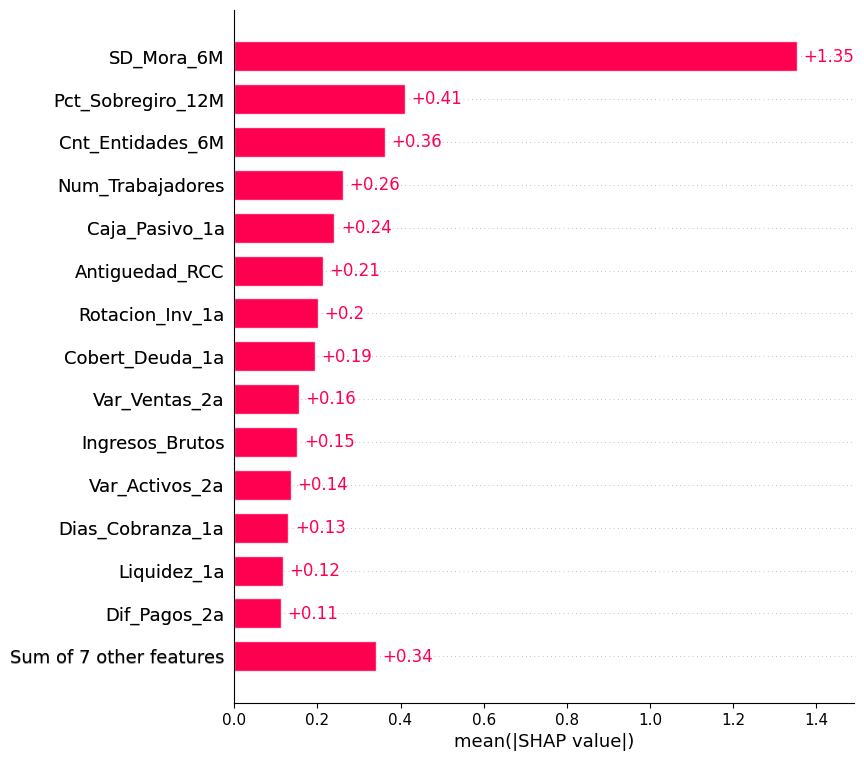

In [57]:
# Construir Explanation correctamente para todo el conjunto de prueba
# La API moderna de SHAP devuelve un Explanation con dimensiones consistentes
explanation = explainer(X_test)

# Bar Plot - Importancia Global (Media de |SHAP|)
shap.plots.bar(explanation, max_display=15)


### 🔍 Análisis del Bar Plot
**Top 3 Variables más importantes:**
1. `SD_Mora_6M` - Desviación estándar de días de mora (Sistema Financiero).
2. `Cnt_Entidades_6M` - Máximo número de entidades financieras consultadas.
3. `Dif_Pagos_2a` - Diferencia en promedio de días de pago.

> **⚠️ Limitación:** El bar plot NO nos dice si valores altos de estas variables **aumentan** o **disminuyen** el riesgo. Para eso necesitamos el Beeswarm.

---
### 3.2 Beeswarm Plot: Importancia + Dirección 🐝
El "gráfico de abejas" es el más completo. Cada punto es un cliente.

**Cómo leerlo:**
| Elemento | Significado |
|----------|-------------|
| **Posición Y** | Variables arriba = más importantes |
| **Color Rojo** | El cliente tiene valor ALTO de esa variable |
| **Color Azul** | El cliente tiene valor BAJO de esa variable |
| **Posición X (+)** | Aumenta la probabilidad de default |
| **Posición X (-)** | Disminuye la probabilidad de default |

c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: Glyph 128029 (\N{HONEYBEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128029 (\N{HONEYBEE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


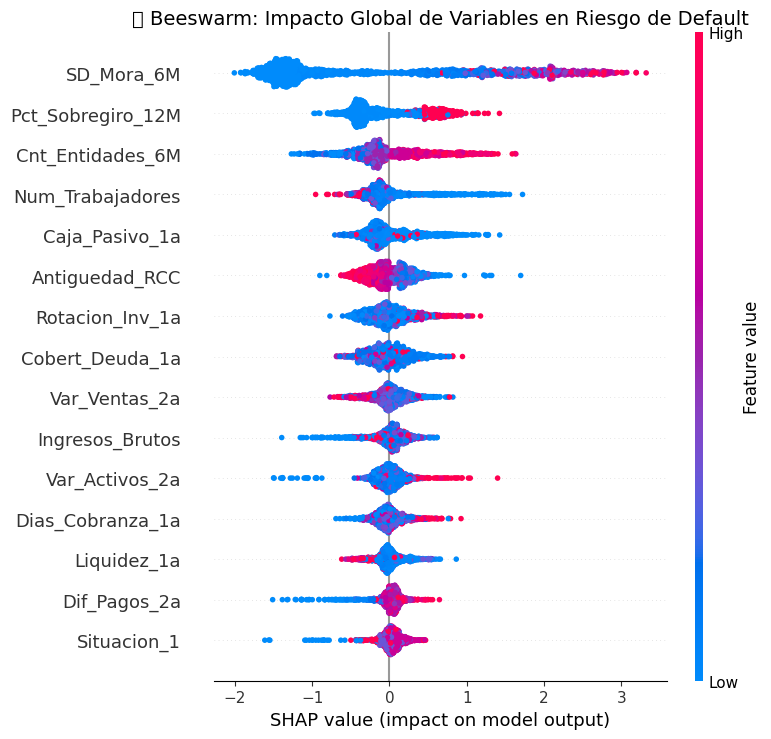

In [58]:
# Beeswarm Plot (Summary Plot con tipo "dot")
plt.figure(figsize=(12, 8))
plt.title("🐝 Beeswarm: Impacto Global de Variables en Riesgo de Default", fontsize=14)
shap.summary_plot(shap_values, X_test, show=True, max_display=15)


### 🔍 Análisis del Beeswarm Plot

**Interpretaciones clave:**

| Variable | Patrón Observado | Interpretación de Negocio |
|----------|------------------|---------------------------|
| `SD_Mora_6M` | Rojo → Derecha | **Alta variabilidad en mora = Mayor riesgo.** Clientes con historial de mora inconsistente son más peligrosos. |
| `Cnt_Entidades_6M` | Rojo → Derecha | **Consultar muchas entidades = Mayor riesgo.** Señal de "desesperación" por crédito. |
| `Num_Trabajadores` | Rojo → Izquierda | **Más trabajadores = Menor riesgo.** Empresas más grandes son más estables. |

> **💡 Insight Clave:** La dispersión de los puntos (ancho horizontal) indica qué tan importante es esa variable. Variables con puntos muy dispersos tienen alto impacto.

---
### 3.3 Heatmap: Patrones por Cliente 🌡️
El heatmap muestra los SHAP values de cada cliente (filas) para cada variable (columnas).

**Útil para:**
- Identificar **clusters** de clientes con comportamientos similares.
- Ver si hay **patrones ocultos** en segmentos específicos.

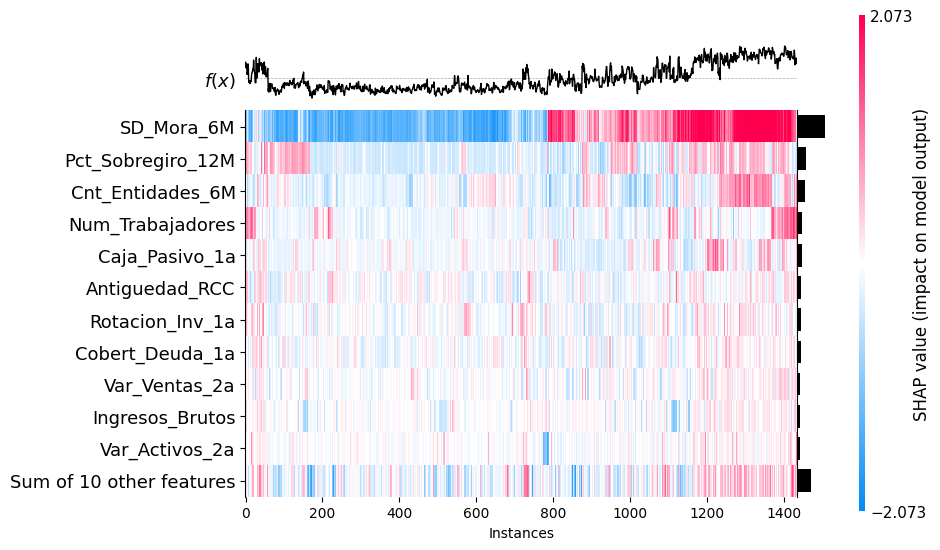

<Axes: xlabel='Instances'>

In [59]:
# Heatmap de SHAP values (muestra de 1000 clientes)
shap.plots.heatmap(explanation, max_display=12)


### 🔍 Análisis del Heatmap
**Cómo leerlo:**
- **Filas:** Cada fila es un cliente (ordenados por predicción).
- **Columnas:** Cada columna es una variable.
- **Color Rojo:** SHAP positivo (aumenta riesgo para ese cliente).
- **Color Azul:** SHAP negativo (disminuye riesgo para ese cliente).
- **Línea negra (f(x)):** Predicción final del modelo para cada cliente.

**Patrones a buscar:**
- ¿Hay "bandas" verticales rojas consistentes? → Esa variable siempre aumenta el riesgo.
- ¿Hay grupos de clientes con patrones similares? → Posibles segmentos.

---
## 4. Interpretación Local 🔍

La interpretación local responde: **"¿Por qué el modelo tomó ESTA decisión para ESTE cliente?"**

Esto es **crítico** para:
- 📋 Cumplimiento regulatorio (GDPR, Ley de Crédito).
- 🤝 Explicar rechazos a clientes.
- 🔍 Auditoría interna de decisiones.

---
### 4.1 Waterfall Plot: Auditoría Individual 💧
El waterfall muestra cómo cada variable "empuja" la predicción desde el promedio hasta el valor final.

In [71]:
np.argsort(probs)

array([  59, 1105, 1352, ...,  958, 1317,  161], dtype=int64)

📋 AUDITORÍA DEL CLIENTE MÁS RIESGOSO
Índice del Cliente: 161
Probabilidad de Default: 98.83%


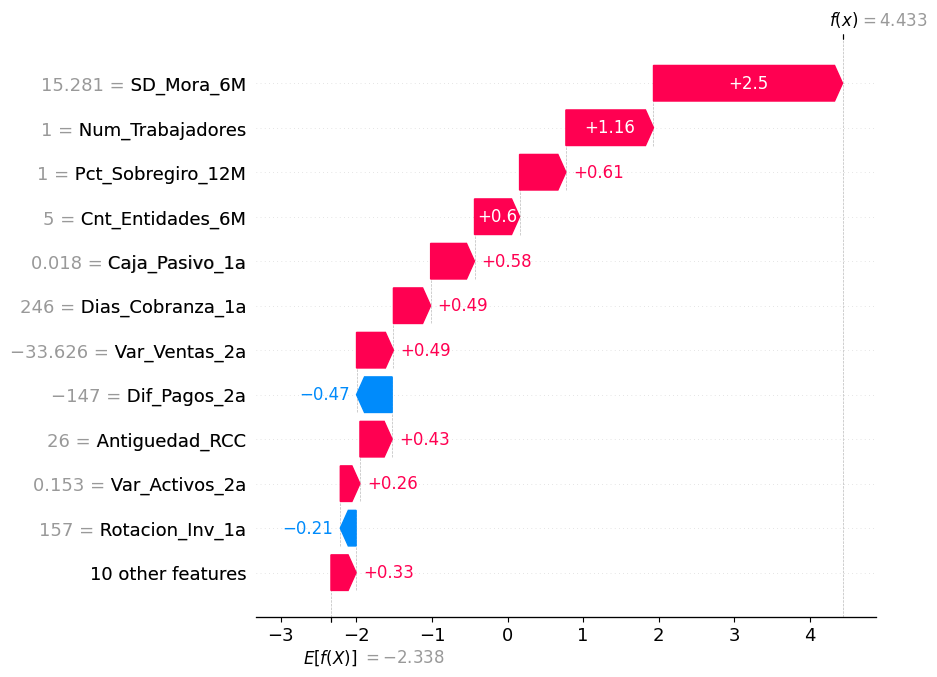

In [74]:
# Elegimos un cliente con alto riesgo para analizar
probs = model.predict_proba(X_test)[:, 1]
high_risk_idx = np.argsort(probs)[-1]  # El cliente más riesgoso

print(f"📋 AUDITORÍA DEL CLIENTE MÁS RIESGOSO")
print(f"{'='*45}")
print(f"Índice del Cliente: {high_risk_idx}")
print(f"Probabilidad de Default: {probs[high_risk_idx]*100:.2f}%")
print(f"{'='*45}")

# Waterfall Plot usando la nueva API
shap.plots.waterfall(explanation[high_risk_idx], max_display=12)


### 🔍 Análisis del Waterfall (Cliente de Alto Riesgo)

**Cómo leerlo:**
- **E[f(x)] = -2.338:** Este es el "score promedio" de todos los clientes (en log-odds).
- **f(x) = 4.433:** Este es el score final del cliente (muy alto = muy riesgoso).
- **Barras Rojas (+):** Variables que AUMENTAN el riesgo de este cliente.
- **Barras Azules (-):** Variables que DISMINUYEN el riesgo de este cliente.

**¿Por qué rechazamos a este cliente?** (Basado en el gráfico)
1. `SD_Mora_6M = 15.28` → Contribuye **+2.5** al score (ENORME).
2. `Num_Trabajadores = 1` → Contribuye **+1.16** (microempresa, más riesgo).
3. `Pct_Sobregiro_12M` → Contribuye **+0.61** (sobregiros).

> **📝 Para el Regulador:** "Señor cliente, su crédito fue rechazado principalmente porque su historial muestra alta variabilidad en días de mora (SD=15.28), opera como microempresa (1 trabajador), y tiene alto porcentaje de sobregiro."

---
### 4.2 Decision Plot: El Camino de la Predicción 🛤️
El Decision Plot muestra cómo la predicción "viaja" desde el valor base hasta el valor final, atravesando cada variable.

**Útil para:**
- Ver el **camino completo** de la decisión.
- Comparar **múltiples clientes** simultáneamente.
- Identificar dónde "divergen" los clientes buenos de los malos.

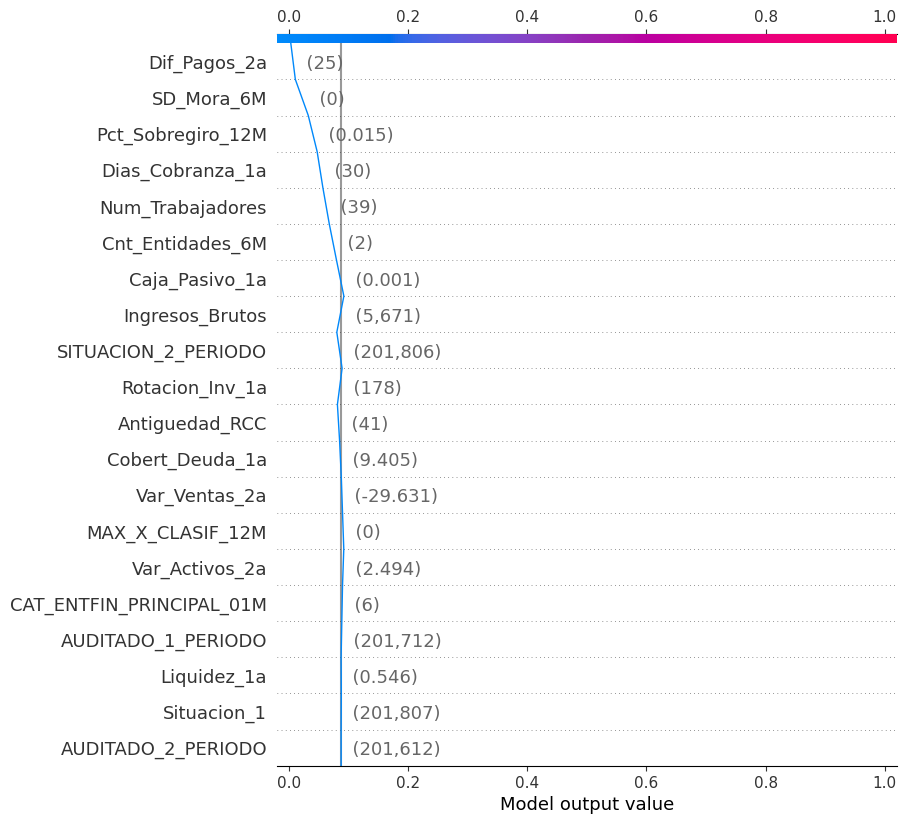

In [77]:
# Decision Plot - Muestra el "camino" de la predicción
# Usamos expected_value[1] porque es clasificación binaria (clase 1 = default)
shap.decision_plot(
    explainer.expected_value,  # Base value para clase 1
    shap_values_default[:100],     # SHAP values de 50 clientes
    X_test.iloc[:100],             # Features de esos clientes
    feature_names=X_test.columns.tolist(),
    link='logit'                  # Transforma a probabilidad
)


### 🔍 Análisis del Decision Plot

**Cómo leerlo:**
- Cada **línea** es un cliente.
- El eje Y muestra las variables (de menos a más importante hacia arriba).
- Las líneas empiezan en el valor base (izquierda) y terminan en su predicción final.
- **Líneas que van a la derecha** = Clientes de alto riesgo.
- **Líneas que van a la izquierda** = Clientes de bajo riesgo.

**Insight:**
Observa cómo las líneas "divergen" dramáticamente en las variables superiores (`SD_Mora_6M`). Esto confirma que es la variable más discriminante.

---
## 5. Análisis de Variables Específicas 📊

A veces queremos entender **cómo se comporta una variable específica**. Los scatter plots de SHAP nos permiten ver relaciones no lineales.

---
### 5.1 Scatter Plot: Relación Variable vs SHAP
Veamos cómo `SD_MAX_DIAS_MORA_SSFF_06M` afecta el riesgo:

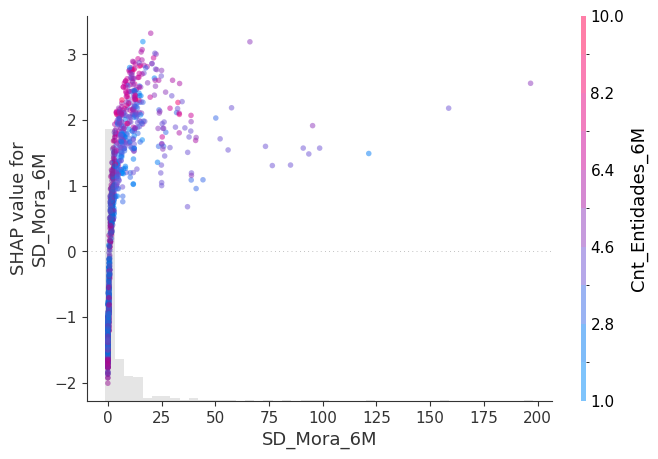

In [62]:
# Scatter Plot: SD_Mora_6M (antes SD_MAX_DIAS_MORA_SSFF_06M)
shap.plots.scatter(
    explanation[:, "SD_Mora_6M"],
    color=explanation,  # Colorea por la variable de mayor interacción
    alpha=0.5
)

### 🔍 Análisis del Scatter Plot (Días de Mora)

**Cómo leerlo:**
- **Eje X:** Valor real de la variable (SD de días de mora).
- **Eje Y:** SHAP value (contribución al riesgo).
- **Color:** Variable con mayor interacción.

**Interpretación:**
- Cuando `SD_Mora_6M ≈ 0` → SHAP ≈ -1 (REDUCE el riesgo).
- Cuando `SD_Mora_6M > 10` → SHAP > +1 (AUMENTA el riesgo).
- La relación es **no lineal**: el riesgo aumenta exponencialmente a partir de cierto umbral.

> **💼 Aplicación:** Podríamos crear una regla de negocio: "Si SD_Mora_6M > 10, revisar manualmente antes de aprobar."

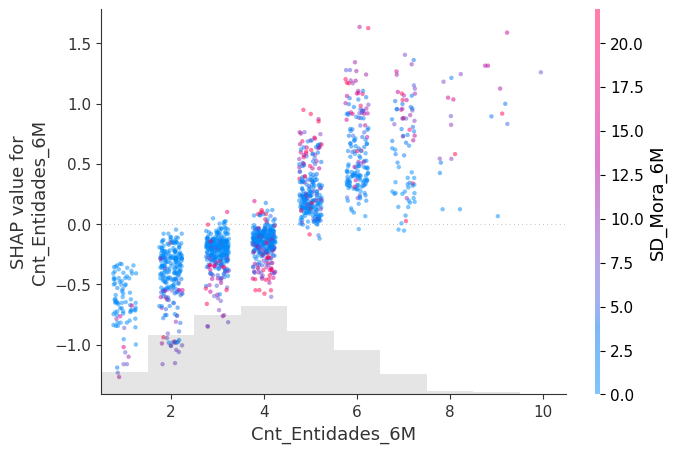

In [63]:
# Scatter Plot: Cnt_Entidades_6M (antes MAX_CNT_ENTIDADES_SSFF_06M)
shap.plots.scatter(
    explanation[:, "Cnt_Entidades_6M"],
    dot_size=10,
    x_jitter=0.5,  # Agrega ruido horizontal para variables discretas
    color=explanation,
    alpha=0.5
)

### 🔍 Análisis del Scatter Plot (Entidades Consultadas)

**Interpretación:**
- Cuando `Cnt_Entidades_6M = 0-2` → SHAP negativo (bajo riesgo).
- Cuando `Cnt_Entidades_6M > 5` → SHAP positivo (alto riesgo).

**¿Por qué es discreto?** Esta variable cuenta el número de entidades financieras. Por eso usamos `x_jitter` para separar los puntos y ver mejor la distribución.

> **💼 Insight de Negocio:** Consultar muchas entidades financieras en poco tiempo es señal de "shopping de crédito" - el cliente está buscando desesperadamente financiamiento, lo cual es un red flag.

---
## 6. 🧠 Micro-Desafío: El Cliente "Bueno"

Hemos analizado al cliente más riesgoso. Ahora te toca a ti.

**Tu tarea:**
1. Encuentra al cliente con la **menor** probabilidad de default.
2. Genera su `waterfall` plot.
3. ¿Qué variables lo están "salvando"? (Barras azules grandes).

```python
# Tu código aquí:
low_risk_idx = np.argsort(probs)[0]  # Cliente menos riesgoso
print(f"Probabilidad de Default: {probs[low_risk_idx]*100:.2f}%")
shap.plots.waterfall(explanation[low_risk_idx], max_display=12)
```

> **💡 Pro-Tip:** SHAP es computacionalmente costoso. En producción, no calculamos SHAP para todos. Solo lo calculamos "on-demand" cuando un cliente pide una explicación o para auditorías muestrales.

---
## 📋 Resumen: Galería de Gráficos SHAP

| Gráfico | Nivel | Pregunta que responde | Cuándo usarlo |
|---------|-------|----------------------|---------------|
| **Bar Plot** | Global | ¿Cuáles son las TOP variables? | Presentaciones ejecutivas, ranking rápido |
| **Beeswarm** | Global | ¿Valores altos aumentan o bajan el riesgo? | Análisis exploratorio, entender direccionalidad |
| **Heatmap** | Global | ¿Hay clusters de clientes similares? | Segmentación, buscar patrones ocultos |
| **Waterfall** | Local | ¿Por qué esta decisión para este cliente? | Auditoría regulatoria, explicar rechazos |
| **Decision Plot** | Local | ¿Cuál fue el "camino" de la predicción? | Comparar múltiples clientes, debugging |
| **Scatter** | Variable | ¿Cómo afecta esta variable específica? | Análisis profundo, detectar no-linealidades |

---
## 🎯 Key Takeaways

1. **SHAP vs Feature Importance tradicional:** SHAP suma a la predicción real (es aditivo). Feature Importance solo ordena por "importancia" sin dirección.

2. **Global vs Local:** 
   - Global → "¿Qué mueve al modelo EN GENERAL?"
   - Local → "¿Por qué ESTE cliente tiene ESTE score?"

3. **En producción:** No calcules SHAP para todos los clientes (es costoso). Úsalo on-demand para auditorías o cuando el cliente lo solicite.

4. **Variables clave identificadas:**
   - `SD_Mora_6M`: Alta variabilidad en mora = ALTO RIESGO
   - `Cnt_Entidades_6M`: Muchas consultas = ALTO RIESGO
   - `Num_Trabajadores`: Más empleados = BAJO RIESGO

---
## 7. Gráficos Interactivos de SHAP 🎮

Los gráficos interactivos de SHAP permiten **explorar dinámicamente** las predicciones del modelo. A diferencia de los gráficos estáticos, puedes:
- 🖱️ Pasar el mouse sobre los elementos para ver detalles
- 🔍 Hacer zoom en áreas específicas
- 📊 Explorar las contribuciones de cada variable

> **⚠️ Nota:** Estos gráficos requieren que `shap.initjs()` se haya ejecutado previamente (ya está en la primera celda).

---
### 7.1 Force Plot Individual: Explicación Visual Interactiva
El Force Plot muestra cómo cada variable "empuja" la predicción desde el valor base hacia el valor final. Las barras rojas empujan hacia arriba (mayor riesgo) y las azules hacia abajo (menor riesgo).

In [64]:
# Force Plot Individual - Cliente de Alto Riesgo
# Este gráfico es INTERACTIVO: pasa el mouse sobre las barras para ver detalles

# Recalculamos probabilidades y encontramos el cliente más riesgoso
probs = model.predict_proba(X_test)[:, 1]
high_risk_idx_local = np.argmax(probs)  # Índice del cliente con mayor probabilidad

print(f"🎯 Force Plot del Cliente más Riesgoso (Probabilidad: {probs[high_risk_idx_local]*100:.2f}%)")
print("="*60)

# Usamos el objeto explanation que ya está calculado y sincronizado con X_test
# Extraemos los SHAP values para la clase 1 (default)
shap_vals_cliente = explanation[high_risk_idx_local].values
features_cliente = X_test.iloc[high_risk_idx_local]

# Force Plot usando la API de JavaScript (interactivo)
shap.force_plot(
    explanation.base_values[high_risk_idx_local],  # Base value
    shap_vals_cliente,                              # SHAP values del cliente
    features_cliente,                               # Features del cliente
    matplotlib=False                                # False = JavaScript interactivo
)

🎯 Force Plot del Cliente más Riesgoso (Probabilidad: 98.83%)


### 🔍 Cómo leer el Force Plot
- **Base Value:** El valor promedio de predicción del modelo
- **Output Value:** La predicción final para este cliente específico
- **Barras Rojas:** Variables que AUMENTAN el riesgo (empujan a la derecha)
- **Barras Azules:** Variables que DISMINUYEN el riesgo (empujan a la izquierda)
- **Tamaño de la barra:** Magnitud de la contribución

---
### 7.2 Force Plot Múltiple: Comparación de Clientes
El Force Plot también puede mostrar múltiples clientes a la vez, apilados verticalmente. Esto permite identificar patrones y comparar comportamientos.

In [65]:
# Force Plot Múltiple - Primeros 100 clientes ordenados por predicción
# INTERACTIVO: Haz scroll horizontal y pasa el mouse para explorar

# Ordenamos por probabilidad para ver la transición de bajo a alto riesgo
n_samples = min(100, len(probs))  # No exceder el número de muestras disponibles
sorted_idx = np.argsort(probs)[:n_samples]

print(f"🎯 Force Plot de {n_samples} Clientes (ordenados de menor a mayor riesgo)")
print("="*60)
print("💡 Tip: Haz scroll horizontal para explorar todos los clientes")

# Usamos explanation.values que está sincronizado con X_test
shap.force_plot(
    explanation.base_values[0],           # Base value (es el mismo para todos)
    explanation[sorted_idx].values,       # SHAP values de los clientes seleccionados
    X_test.iloc[sorted_idx],              # Features de esos clientes
    matplotlib=False
)

🎯 Force Plot de 100 Clientes (ordenados de menor a mayor riesgo)
💡 Tip: Haz scroll horizontal para explorar todos los clientes


### 🔍 Análisis del Force Plot Múltiple
**Cómo leerlo:**
- Cada **línea vertical** representa un cliente
- El eje X muestra el valor de predicción (log-odds)
- Los colores muestran qué variables contribuyen más
- Puedes hacer **hover** sobre cualquier cliente para ver sus detalles

**Patrones a observar:**
- ¿Las mismas variables dominan en todos los clientes de alto riesgo?
- ¿Hay "bloques" de color consistentes? → Esa variable es dominante

---
### 7.3 Summary Plot Interactivo: Exploración Dinámica
Una versión interactiva del Beeswarm que permite explorar cada punto individualmente.

In [66]:
# Comparación Interactiva: Cliente de Alto Riesgo vs Cliente de Bajo Riesgo
low_risk_idx_local = np.argmin(probs)   # Cliente menos riesgoso
high_risk_idx_local = np.argmax(probs)  # Cliente más riesgoso

print("📊 COMPARACIÓN: Cliente de Bajo Riesgo vs Alto Riesgo")
print("="*60)
print(f"🟢 Cliente Bajo Riesgo - Probabilidad: {probs[low_risk_idx_local]*100:.2f}%")
print(f"🔴 Cliente Alto Riesgo - Probabilidad: {probs[high_risk_idx_local]*100:.2f}%")
print("="*60)

# Force Plot del cliente de bajo riesgo usando explanation
print("\n🟢 Force Plot - Cliente de BAJO Riesgo:")
shap.force_plot(
    explanation.base_values[low_risk_idx_local],
    explanation[low_risk_idx_local].values,
    X_test.iloc[low_risk_idx_local],
    matplotlib=False
)

📊 COMPARACIÓN: Cliente de Bajo Riesgo vs Alto Riesgo
🟢 Cliente Bajo Riesgo - Probabilidad: 0.15%
🔴 Cliente Alto Riesgo - Probabilidad: 98.83%

🟢 Force Plot - Cliente de BAJO Riesgo:


---
### 7.4 Dependence Plot Interactivo
Explora cómo una variable específica afecta las predicciones, con interacción automática.

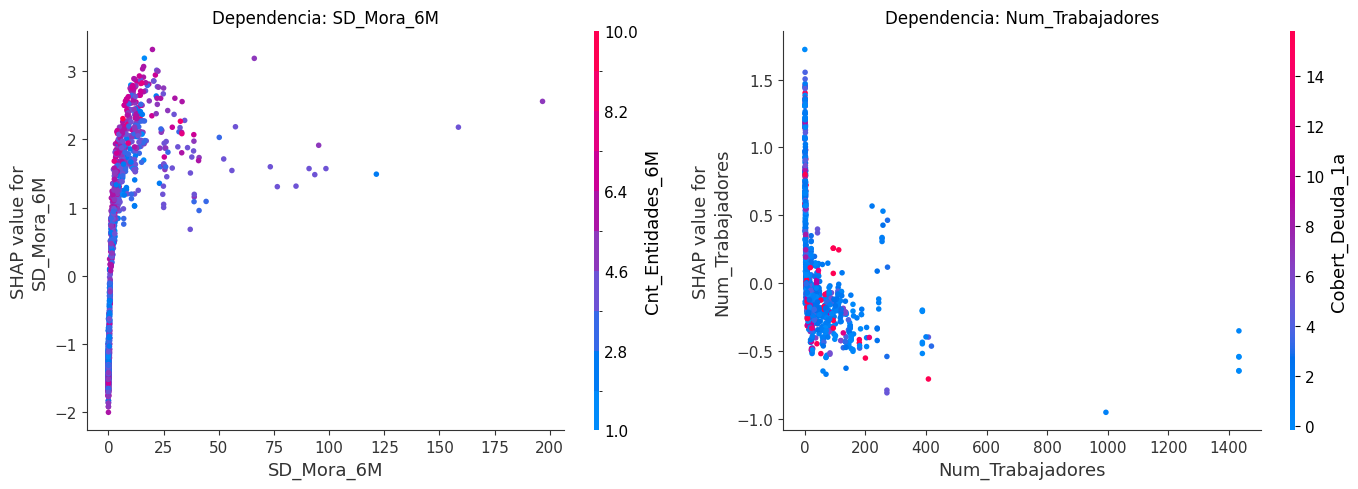

In [67]:
# Dependence Plot con detección automática de interacción
# SHAP detecta automáticamente la variable con mayor interacción y la usa para colorear

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Usamos explanation.values que está sincronizado con X_test
shap_vals = explanation.values

# Plot 1: SD_Mora_6M
plt.sca(axes[0])
shap.dependence_plot(
    "SD_Mora_6M", 
    shap_vals, 
    X_test,
    interaction_index="auto",  # SHAP detecta la mejor interacción
    ax=axes[0],
    show=False
)
axes[0].set_title("Dependencia: SD_Mora_6M", fontsize=12)

# Plot 2: Num_Trabajadores  
plt.sca(axes[1])
shap.dependence_plot(
    "Num_Trabajadores", 
    shap_vals, 
    X_test,
    interaction_index="auto",
    ax=axes[1],
    show=False
)
axes[1].set_title("Dependencia: Num_Trabajadores", fontsize=12)

plt.tight_layout()
plt.show()

### 🔍 Análisis de Dependencias
**¿Qué muestra el color?**
- SHAP detecta automáticamente qué otra variable **interactúa** más con la variable principal
- El color indica el valor de esa variable de interacción
- Si ves patrones de color claros → hay una interacción significativa

**Ejemplo de interpretación:**
- Si en `SD_Mora_6M` los puntos rojos (alta interacción) están más arriba → esa combinación de variables aumenta aún más el riesgo

---
## 📋 Resumen: Gráficos Interactivos SHAP

| Gráfico | Interactividad | Mejor uso |
|---------|----------------|-----------|
| **Force Plot Individual** | Hover para ver detalles | Explicar UNA decisión específica |
| **Force Plot Múltiple** | Scroll + hover | Comparar grupos de clientes |
| **Dependence Plot** | Detección auto de interacción | Encontrar relaciones complejas |

> **💡 Pro-Tip:** Los gráficos interactivos son ideales para **presentaciones en vivo** donde puedes explorar casos específicos en tiempo real con stakeholders.